In [46]:
# 1.2 Import modules.
import numpy as np
import tensorflow as tf
import struct
import matplotlib.pyplot as plt

In [47]:
# 1.3 Read in the data set
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
    
training_data = read_idx('./MNIST/train-images-idx3-ubyte')
training_labels = read_idx('./MNIST/train-labels-idx1-ubyte')
validation_data = read_idx('./MNIST/t10k-images-idx3-ubyte')
validation_labels = read_idx('./MNIST/t10k-labels-idx1-ubyte')

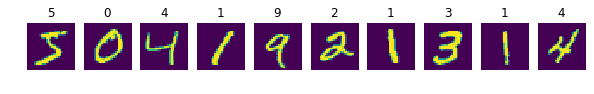

In [48]:
# 1.4 Investigate the data.
fig, ax = plt.subplots(1,10,figsize=(10,10))
for i in range(10):
    ax[i].imshow(training_data[i])
    ax[i].axis('off')
    ax[i].set_title(training_labels[i])

In [49]:
# 1.5
tf.reset_default_graph()

# Create the dataset.
training_dataset = tf.data.Dataset.from_tensor_slices((training_data, training_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_data, validation_labels))

# Specify the batch sizes.
training_batch_size = 128
validation_batch_size = 10000
training_dataset = training_dataset.batch(training_batch_size)
validation_dataset = validation_dataset.batch(validation_batch_size)

# Shuffle the training data in each iteration.
training_dataset = training_dataset.shuffle(buffer_size = 60000)

In [50]:
# 1.6
# Create the iterator.
iterator = tf.data.Iterator.from_structure(training_dataset.output_types,
                                           training_dataset.output_shapes)

# Name the operation that will give the next batch and name the 
# initialization operations.
next_batch = iterator.get_next()
training_init_op = iterator.make_initializer(training_dataset)
validation_init_op = iterator.make_initializer(validation_dataset)

In [51]:
# 2.1
# Read out input data and label from the next batch
input_data  = next_batch[0]
labels = next_batch[1]

# Reshape and cast input data.
input_data = tf.reshape(input_data,shape=[-1,784])
input_data = tf.cast(input_data, tf.float32)

# One-hot and cast labels.
labels = tf.cast(labels, tf.int64)
labels_onehot = tf.one_hot(labels, depth=10)

In [52]:
# 2.2 
# Define the variables, i.e. weights and biases.
weights= tf.Variable(tf.random_normal([784, 10], stddev = 0.000002))
biases = tf.Variable(tf.zeros([10]))

# Define the logits and the output.
logits = tf.matmul(input_data, weights) + biases
output = tf.nn.softmax(logits)

In [53]:
# 2.3
# Define the loss.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels_onehot, logits=logits )
loss = tf.reduce_mean(cross_entropy)

# Define the accuracy.
accuracy = tf.equal(tf.argmax(output, 1), labels)
accuracy = tf.reduce_mean(tf.cast(accuracy, tf.float32))

In [54]:
# 2.4
# Define the learning rate and the optimizer.
learning_rate = 1e-5
optimizer = tf.train.GradientDescentOptimizer(learning_rate)

# Specify the training step.
training_step = optimizer.minimize(loss)

In [55]:
# 2.5
# Define the summaries.
tf.summary.scalar('loss', loss)
tf.summary.scalar('accuracy', accuracy)

# Merge summaries.
merged_summaries = tf.summary.merge_all()

# Instantiate File Writer.
train_writer = tf.summary.FileWriter('./summaries/train/')
validation_writer = tf.summary.FileWriter('./summaries/validation/', flush_secs=2)

In [56]:
# 3.1 
epochs = 4
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    global_step = 0 
    
    # 3.2
    for _ in range(epochs):
        
        
        # 3.3
        # Initialize the iterator with the training data.
        sess.run(training_init_op)
        # Go through all batches.
        while True:
            try:
                # Train and read out summaries.
                _, summaries = sess.run((training_step, merged_summaries))
                # Save summaries.
                train_writer.add_summary(summaries, global_step)
                # Increment global step counter.
                global_step += 1
            except tf.errors.OutOfRangeError:
                break
             
            
        # 3.4
        # Initialize the iterator with the validation data.
        sess.run(validation_init_op)
        # Read out and save the summaries.
        summaries = sess.run((merged_summaries))
        validation_writer.add_summary(summaries, global_step)
                    
        
